In [1]:
import pandas as pd
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community.centrality import girvan_newman

In [2]:
df = pd.read_csv("wiki-Vote.txt")
df.iloc[:, [0]].astype(str)

,# FromNodeId\tToNodeId
0,30\t1412
1,30\t3352
2,30\t5254
3,30\t5543
4,30\t7478
...,...
103684,8272\t4940
103685,8273\t4940
103686,8150\t8275
103687,8150\t8276


Split "FromNodeId\tToNodeId" column to 2 columns that shows nodes that are connected by an edge.

In [3]:
df_revised = pd.Series(df.iloc[:, [0]].values.flatten())
def_revised = df_revised[:].str.split("\t", expand = True)
wiki_vote = def_revised.set_axis(['from', 'to'], axis=1)
wiki_vote.head(10)

,from,to
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478
5,3,28
6,3,30
7,3,39
8,3,54
9,3,108


### Create a graph based on "wiki_vote" data frame.

In [4]:
G_wiki_vote = nx.Graph()

In [5]:
G_wiki_vote = nx.from_pandas_edgelist(wiki_vote, 'from', 'to')

Number of nodes and edges in G_wiki_vote graph.

In [6]:
print(f"number of nodes: {G_wiki_vote.number_of_nodes()}")
print(f"number of edges: {G_wiki_vote.number_of_edges()}")

number of nodes: 7115
number of edges: 100762


To find the diameter in our graph we should make sure that we have a connected graph. Based on result of below code we do not have connected graph. Therefore, after running nx.diameter we got an error: Found infinite path length because the graph is not connected.

In [7]:
nx.is_connected(G_wiki_vote)

False

Instead of using diameter we can find diameter in each components. First we need to find how many components we have. In our graph we have 24 components and the first component has highest number of nodes. 

In [8]:
con_component_total = [len(con_component) for con_component in sorted(nx.connected_components(G_wiki_vote), key=len, reverse=True)]
print(f"number of nodes in each component: {con_component_total}")
print(f"number of connected components: {len(con_component_total)}")


number of nodes in each component: [7066, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
number of connected components: 24


The longethst shortest path in each component from giant component to smallest component provided in below. As we expected the diameter in gaint component has higher value and we need to pass 7 edges to connect nodes that are far from each other.

In [9]:
diameter_of_components = [nx.diameter(G_wiki_vote.subgraph(component).copy()) for component in 
                          sorted(nx.connected_components(G_wiki_vote),key = len, reverse = True)]
print(diameter_of_components)

[7, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
print(nx.transitivity(G_wiki_vote))

0.12547914899233995


In [11]:
print(nx.average_clustering(G_wiki_vote))

0.14089784589308738


#### Analyze degree of nodes in our graph:

In [12]:
degree_sequence = sorted((degree for node, degree in G_wiki_vote.degree()), reverse=True)
print(f"maximum degree of a node: {max(degree_sequence)}")
print(f"minimum degree of a node: {min(degree_sequence)}")

maximum degree of a node: 1065
minimum degree of a node: 1


Based on degree histogram, we can see that number of nodes with low degree is much higher than number of nodes with higher degree. Therefore, this plot follow power law distribution. As we know degree distribution in random network does not follow power law. we can say that our graph is not random network. On the other side probablity of existing edge between 2 nodes is p = m/(n*(n-1)/2)= 3.9*10^(-3) that is smaller than c and we cant say that our graph is random network.

In [13]:
#function for making plots in regular scale
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
def MakePlots(G, title):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 8)

    ax0 = fig.add_subplot(axgrid[1:, :4])
    ax0.plot(degree_sequence, "b-", marker="o")
    ax0.set_title("Degree Rank Plot")
    ax0.set_ylabel("Degree")
    ax0.set_xlabel("Rank")

    ax1 = fig.add_subplot(axgrid[1:, 4:])
    ax1.bar(*np.unique(degree_sequence, return_counts=True))
    ax1.set_title("Degree histogram")
    ax1.set_xlabel("Degree")
    ax1.set_ylabel("Number of Nodes")

    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.savefig(title+".png")
    plt.show()

In [14]:
#function for making plots in log log scale
# https://networkx.org/documentation/stable/auto_examples/drawing/plot_degree.html
def MakePlots_loglog(G, title):
    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(8)
    # Create a gridspec for adding subplots of different sizes
    axgrid = fig.add_gridspec(5, 8)

    ax0 = fig.add_subplot(axgrid[1:, :4])
    ax0.plot(degree_sequence, "b-", marker="o")
    ax0.set_title("Degree Rank Plot")
    ax0.set_ylabel("Degree (log scale)")
    ax0.set_xlabel("Rank (log scale)")
    ax0.set_xscale('log')
    ax0.set_yscale('log')

    ax1 = fig.add_subplot(axgrid[1:, 4:])
    ax1.bar(*np.unique(degree_sequence, return_counts=True))
    ax1.set_title("Degree histogram")
    ax1.set_xlabel("Degree (log scale)")
    ax1.set_ylabel("Number of Nodes (log scale)")
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    fig.suptitle(title, fontsize=16)
    fig.tight_layout()
    plt.savefig(title+".png")
    plt.show()

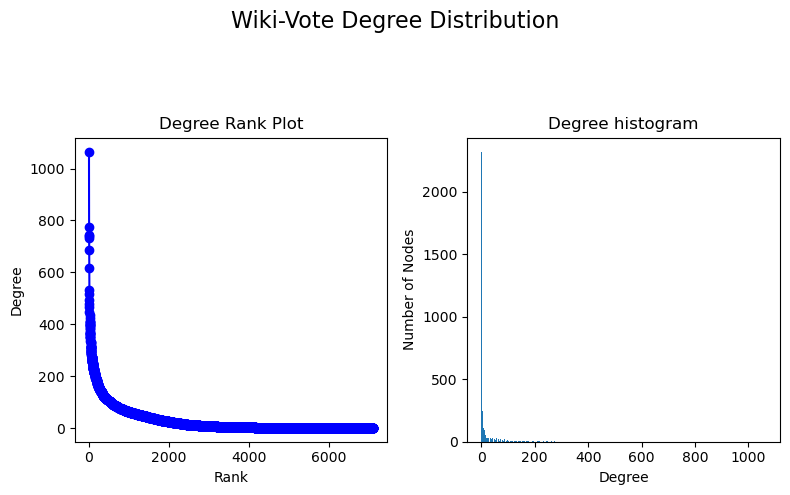

In [15]:
MakePlots(G_wiki_vote, "Wiki-Vote Degree Distribution")

The degree sequence is not a straight line when plotted in log-log scale, so it does not follow a perfect power law, but it also does not follow the binomial distribution that is expected of a random graph.

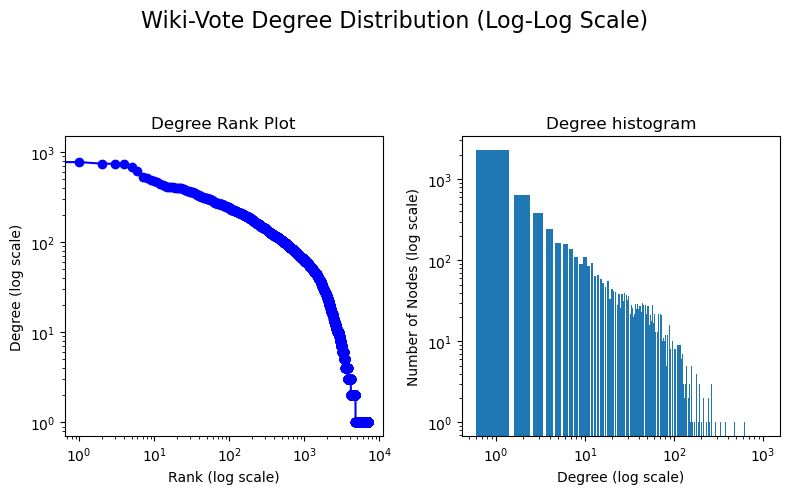

In [16]:
MakePlots_loglog(G_wiki_vote, "Wiki-Vote Degree Distribution (Log-Log Scale)")

#### page rank in wiki-vote graph

To visualize the network with node size with respect to their pagerank, we could not use whole nodes of giant network because we have more than 7000 nodes in this component.
Therefore we used top 20 nodes that have highest degree. 

In [17]:
list_of_nodes_degree = sorted(G_wiki_vote.degree, key=lambda x: x[1], reverse=True)
top_20_nodes = []

data_max = list_of_nodes_degree[0:20]
for j in data_max:
    top_20_nodes.append(j[0])

print(top_20_nodes)

['2565', '766', '11', '1549', '457', '1166', '2688', '1374', '1151', '5524', '3352', '4037', '737', '2485', '2328', '3456', '2871', '5802', '1608', '15']


create a subgraph based on top 20 nodes:

In [18]:
subgraph_for_top_20 = G_wiki_vote.subgraph(top_20_nodes)

print(subgraph_for_top_20.nodes())

['11', '457', '1549', '2485', '1374', '15', '1151', '737', '3456', '5524', '4037', '2565', '766', '2328', '2871', '1166', '3352', '2688', '1608', '5802']


In [19]:
pos_top_20 = nx.spring_layout(subgraph_for_top_20)

In [20]:
pr = nx.pagerank(G_wiki_vote, alpha=0.9)

create a subgraph based on top 20 nodes:

In [21]:
sorted_nodes = sorted([(node, pagerank) for node, pagerank in pr.items()], key=lambda x:pr[x[0]])
node_size_dict = {}
for j in subgraph_for_top_20.nodes():
    for i in sorted_nodes:
        if i[0] == j:
            node_size_dict[i[0]]=i[1]*100000

print(list(node_size_dict.items()))
node_size= list(node_size_dict.values())


[('11', 322.1875064671966), ('457', 315.9567223489791), ('1549', 308.9712560960698), ('2485', 183.66106096824154), ('1374', 228.47219494858726), ('15', 213.00039296981268), ('1151', 218.07953702494726), ('737', 199.11068840043336), ('3456', 175.25940357304464), ('5524', 220.0380490794558), ('4037', 274.178531247823), ('2565', 461.5280393009635), ('766', 321.6984577108322), ('2328', 193.08488834036507), ('2871', 176.63293799800644), ('1166', 288.1654705813677), ('3352', 207.04968489572477), ('2688', 257.3123114404256), ('1608', 170.75531381167238), ('5802', 182.9396017762063)]


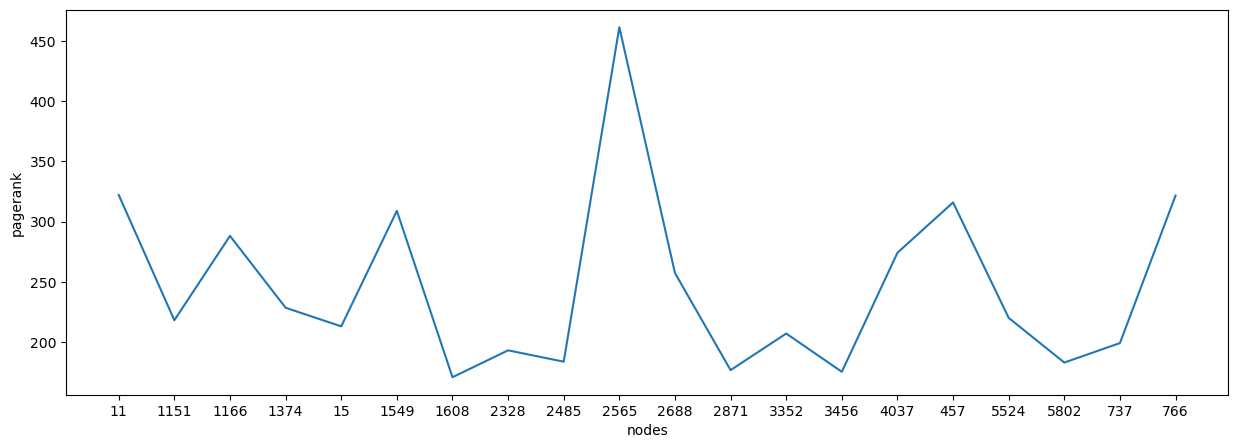

In [22]:
plt.rcParams["figure.figsize"] = [15, 5]
new_x, new_y = zip(*sorted(zip(node_size_dict.keys(),node_size_dict.values())))
plt.plot(new_x, new_y)
plt.xlabel("nodes")
plt.ylabel("pagerank")
plt.show()


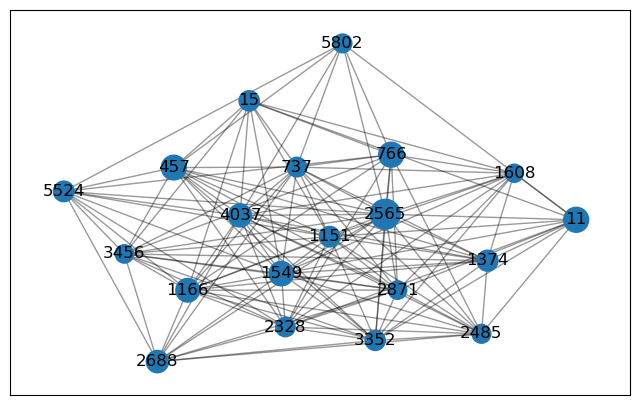

In [23]:
plt.rcParams["figure.figsize"] = [8, 5]
nx.draw_networkx_nodes(subgraph_for_top_20, pos_top_20, node_size=node_size, label=subgraph_for_top_20.nodes())
nx.draw_networkx_edges(subgraph_for_top_20, pos_top_20, alpha = 0.4)
nx.draw_networkx_labels(subgraph_for_top_20,pos_top_20)
plt.show()

### Community based on Girvan-Newman algorithm

In [24]:
list_of_nodes_degree = sorted(G_wiki_vote.degree, key=lambda x: x[1], reverse=True)
subgraph_comunity = []

selected_nodes = list_of_nodes_degree[0:300]

for j in selected_nodes:
    subgraph_comunity.append(j[0])

subgraph_comunity_graph = G_wiki_vote.subgraph(subgraph_comunity)

In [25]:
communities = girvan_newman(subgraph_comunity_graph, most_valuable_edge=None)
node_groups = []
for com in next(communities):
    node_groups.append(list(com))

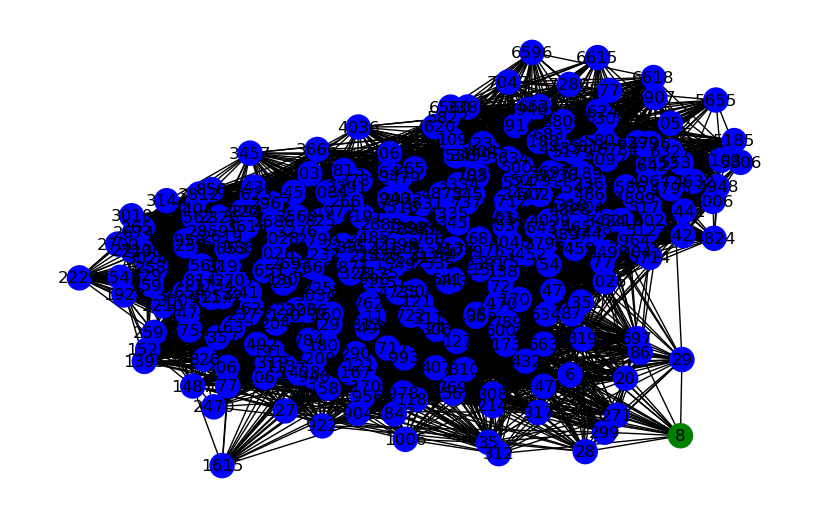

In [26]:
plt.rcParams["figure.figsize"] = [8, 5]

color_map = []
for node in subgraph_comunity_graph:
    if node in node_groups[0]:
        color_map.append("blue")
    else:
        color_map.append("green")
nx.draw(subgraph_comunity_graph, node_color=color_map, with_labels=True)
plt.show()